In [1]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tqdm import tqdm
from skimage.transform import resize

from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from sklearn.metrics import classification_report, confusion_matrix

C:\Users\Ronit kothari\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:

# Define the directories for the training and testing datasets
train_dir = r'D:\brain tumor\custom\Training'
test_dir = r'D:\brain tumor\custom\Testing'

X_train = []  # Training Dataset
Y_train = []  # Training Labels

image_size = 224  # Target size for resizing images

# Load and process training images
print("Processing training images...")
for label in labels:
    path = os.path.join(train_dir, label)
    class_num = labels.index(label)
    
    # Use tqdm for progress tracking
    for img in tqdm(os.listdir(path), desc=f"Processing {label} images", unit="file"):
        img_array = plt.imread(os.path.join(path, img))  # Read the image
        img_resized = resize(img_array, (image_size, image_size, 3))  # Resize the image
        X_train.append(img_resized)  # Add the resized image to the training set
        Y_train.append(class_num)  # Add the label to the training labels

# Load and process testing images (if you also need test data)
print("Processing testing images...")
for label in labels:
    path = os.path.join(test_dir, label)
    class_num = labels.index(label)
    
    # Use tqdm for progress tracking
    for img in tqdm(os.listdir(path), desc=f"Processing {label} test images", unit="file"):
        img_array = plt.imread(os.path.join(path, img))  # Read the image
        img_resized = resize(img_array, (image_size, image_size, 3))  # Resize the image
        X_train.append(img_resized)  # Add the resized image to the training set
        Y_train.append(class_num)  # Add the label to the training labels

# Convert the lists to NumPy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

print("Image loading and processing complete.")

Processing training images...


Processing pituitary images: 100%|███████████████████████████████████████████████| 1457/1457 [00:56<00:00, 25.95file/s]


Processing testing images...


Processing pituitary test images: 100%|████████████████████████████████████████████| 300/300 [00:11<00:00, 26.80file/s]


Image loading and processing complete.


In [4]:
#Number of sample = 7023
X_train.shape 

(7023, 224, 224, 3)

In [5]:
# Shuffling data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

In [6]:
#After shuffling sample size remains same
X_train.shape

(7023, 224, 224, 3)

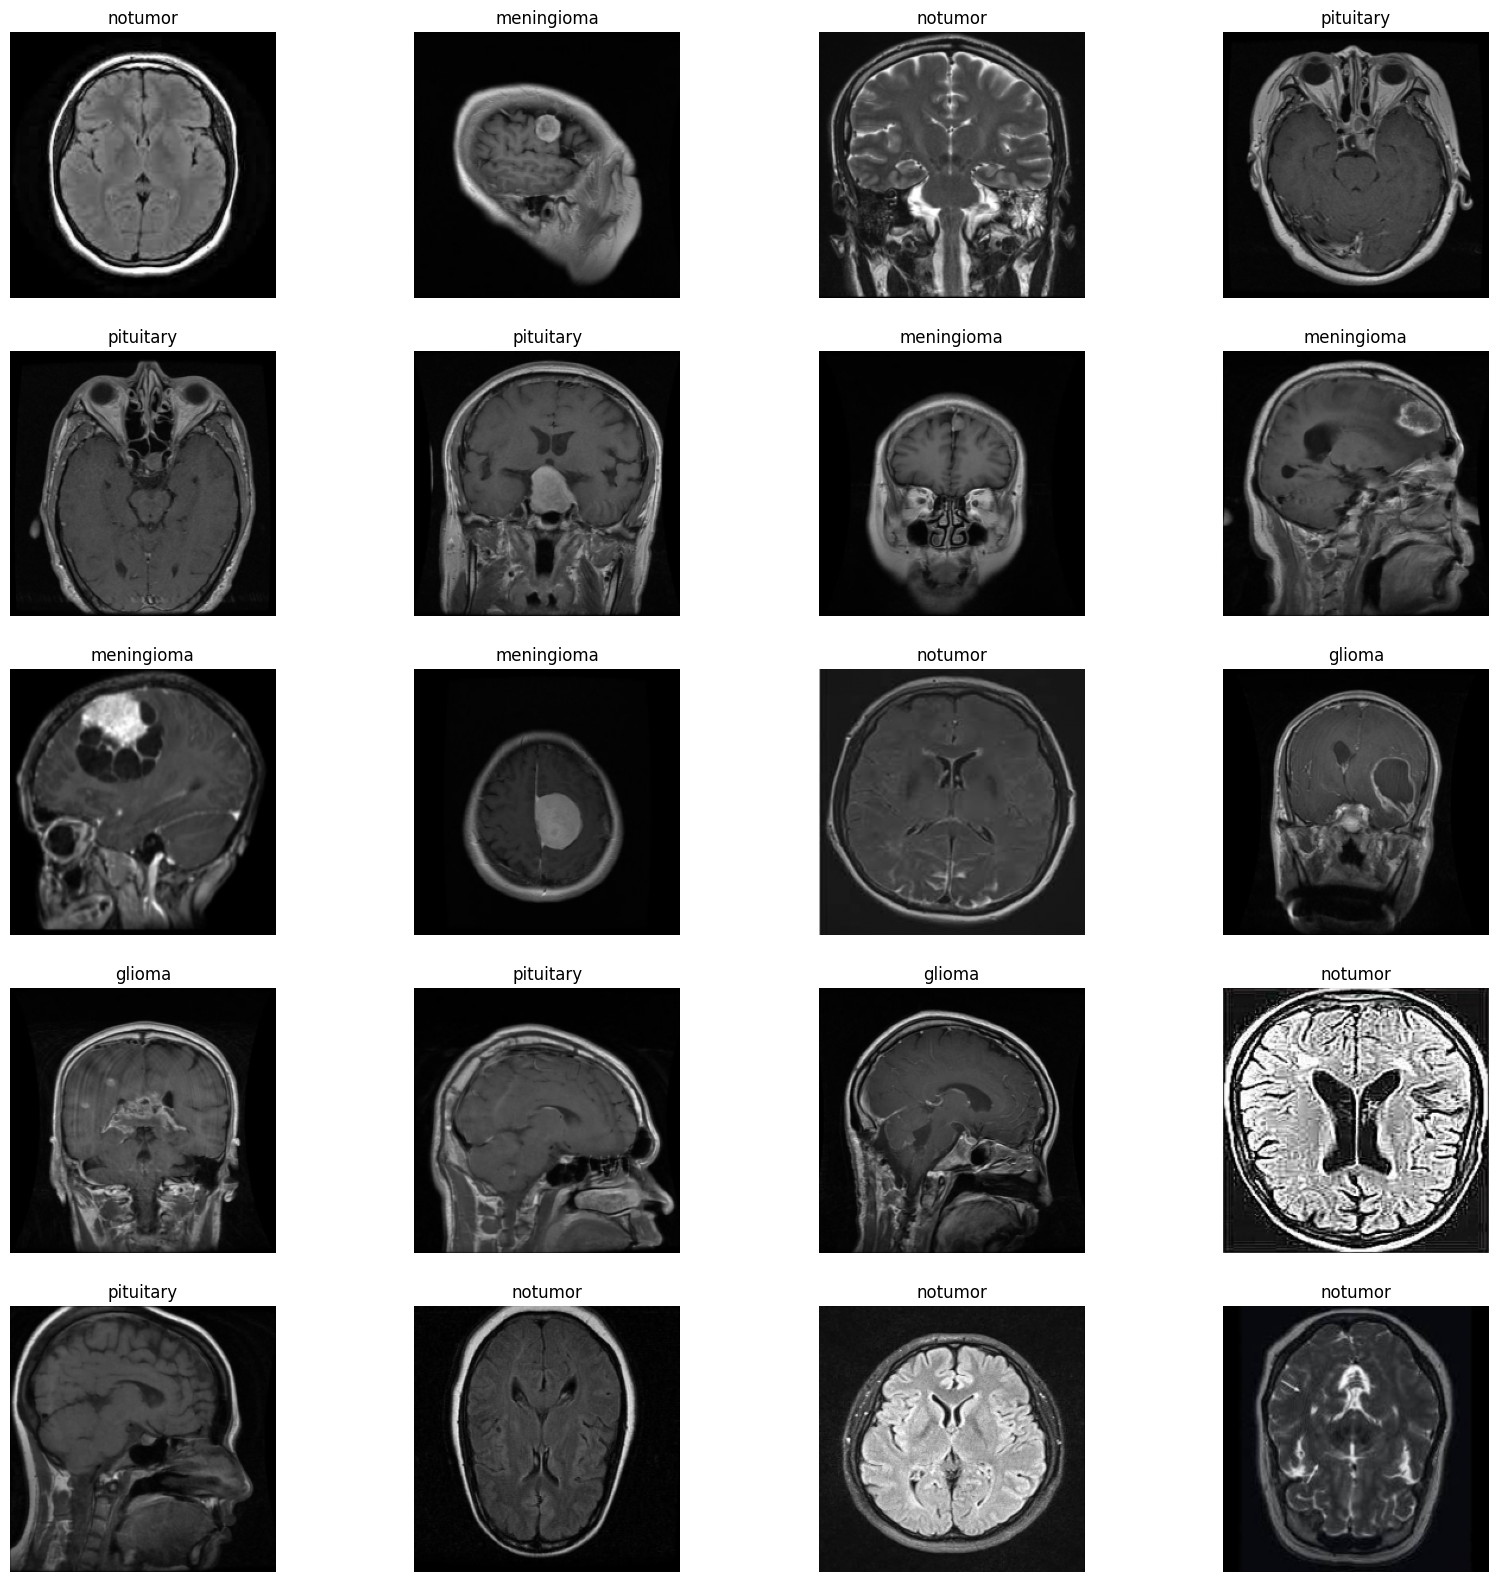

In [7]:
#plotting the images
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_train[i])
    plt.title(labels[Y_train[i]])
    plt.axis("off")
plt.show()

In [14]:
# Split the data into training and testing and validation
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.10, random_state=42)



In [15]:
# Data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

# convert string to categorical
y_train_new = to_categorical(Y_train, num_classes=4)
y_valid_new = to_categorical(Y_valid, num_classes=4)
y_test_new = to_categorical(Y_test, num_classes=4)

In [26]:
# Print the shapes of the augmented data
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_valid: {X_valid.shape}")
print(f"Shape of X_test: {X_test.shape}")

# Print the shapes of the categorical labels
print(f"Shape of y_train_new: {y_train_new.shape}")
print(f"Shape of y_valid_new: {y_valid_new.shape}")
print(f"Shape of y_test_new: {y_test_new.shape}")

Shape of X_train: (1591, 224, 224, 3)
Shape of X_valid: (177, 224, 224, 3)
Shape of X_test: (759, 224, 224, 3)
Shape of y_train_new: (1591, 4)
Shape of y_valid_new: (177, 4)
Shape of y_test_new: (759, 4)


In [16]:
from tensorflow.keras.applications import Xception
img_shape = (224, 224, 3)
base_model =Xception(input_shape=img_shape, include_top=False, weights='imagenet',
                                            pooling= 'max')

model = Sequential([
    base_model,
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(4, activation='softmax')
])
model.compile(Adamax(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('Bmodel.keras', monitor='val_loss', save_best_only=True)


model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 2048)              20861480  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 128)               262272    
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 21124268 (80.58 MB)
Trainable params: 21069740 (80.37 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [17]:
history = model.fit(datagen.flow(X_train, y_train_new, batch_size=32),
                    epochs=10,validation_data=(X_valid, y_valid_new),
                    callbacks=[early_stopping, checkpoint])

Epoch 1/10
50/50 [==============================] - 554s 10s/step - loss: 0.8005 - accuracy: 0.7165 - val_loss: 0.9616 - val_accuracy: 0.6497
Epoch 2/10
50/50 [==============================] - 483s 10s/step - loss: 0.3636 - accuracy: 0.8680 - val_loss: 0.4619 - val_accuracy: 0.7966
Epoch 3/10
50/50 [==============================] - 342s 7s/step - loss: 0.2106 - accuracy: 0.9302 - val_loss: 0.3614 - val_accuracy: 0.8531
Epoch 4/10
50/50 [==============================] - 249s 5s/step - loss: 0.1243 - accuracy: 0.9566 - val_loss: 0.1834 - val_accuracy: 0.9266
Epoch 5/10
50/50 [==============================] - 248s 5s/step - loss: 0.1069 - accuracy: 0.9642 - val_loss: 0.2168 - val_accuracy: 0.9153
Epoch 6/10
50/50 [==============================] - 246s 5s/step - loss: 0.1084 - accuracy: 0.9705 - val_loss: 0.2283 - val_accuracy: 0.9209
Epoch 7/10
50/50 [==============================] - 248s 5s/step - loss: 0.0641 - accuracy: 0.9799 - val_loss: 0.3012 - val_accuracy: 0.9040
Epoch 8/10


24/24 [==============================] - 30s 1s/step - loss: 0.2158 - accuracy: 0.9381


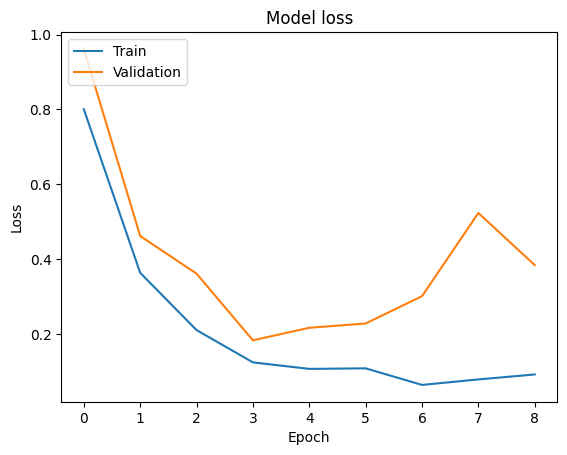

In [18]:
# Evaluate the model
model.evaluate(X_test, y_test_new)

# Plot the accuracy and loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
# Save the model
model.save('Bmodel.keras')
model.save('Bmodel.h5')

C:\Users\Ronit kothari\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - 32s 1s/step


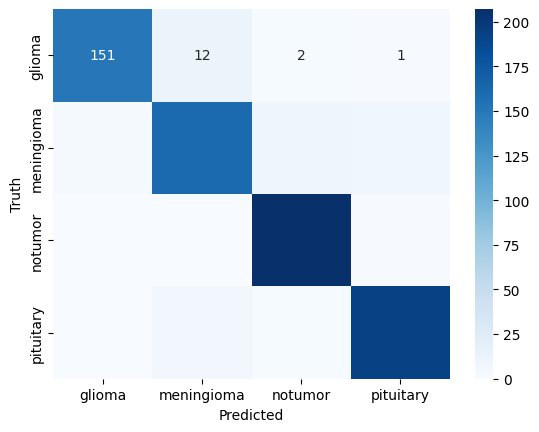

In [20]:
# Load the model
from keras.models import load_model
model = load_model('Bmodel.keras')

# Predict the model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [21]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

      glioma       0.97      0.91      0.94       166
  meningioma       0.89      0.88      0.89       183
     notumor       0.94      1.00      0.97       208
   pituitary       0.95      0.96      0.95       202

    accuracy                           0.94       759
   macro avg       0.94      0.94      0.94       759
weighted avg       0.94      0.94      0.94       759



In [22]:
plt.figure(figsize=(20,20))
for i in range(20):
    plt.subplot(5,4,i+1)
    plt.imshow(X_test[i])
    plt.title(f"Truth: {labels[Y_test[i]]}\nPredicted: {labels[y_pred[i]]}")
    plt.axis('off')
plt.show()

In [23]:
#testing accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(Y_test, y_pred))

0.9380764163372859


In [24]:
# Find and display incorrect predictions
incorrect_indices = np.where(Y_test != y_pred)[0]
num_incorrect = len(incorrect_indices)
percentage_incorrect = (num_incorrect / len(Y_test)) * 100
print(f"Number of incorrect predictions: {num_incorrect}")
print(f"Percentage of incorrect predictions: {percentage_incorrect:.2f}%")

Number of incorrect predictions: 47
Percentage of incorrect predictions: 6.19%


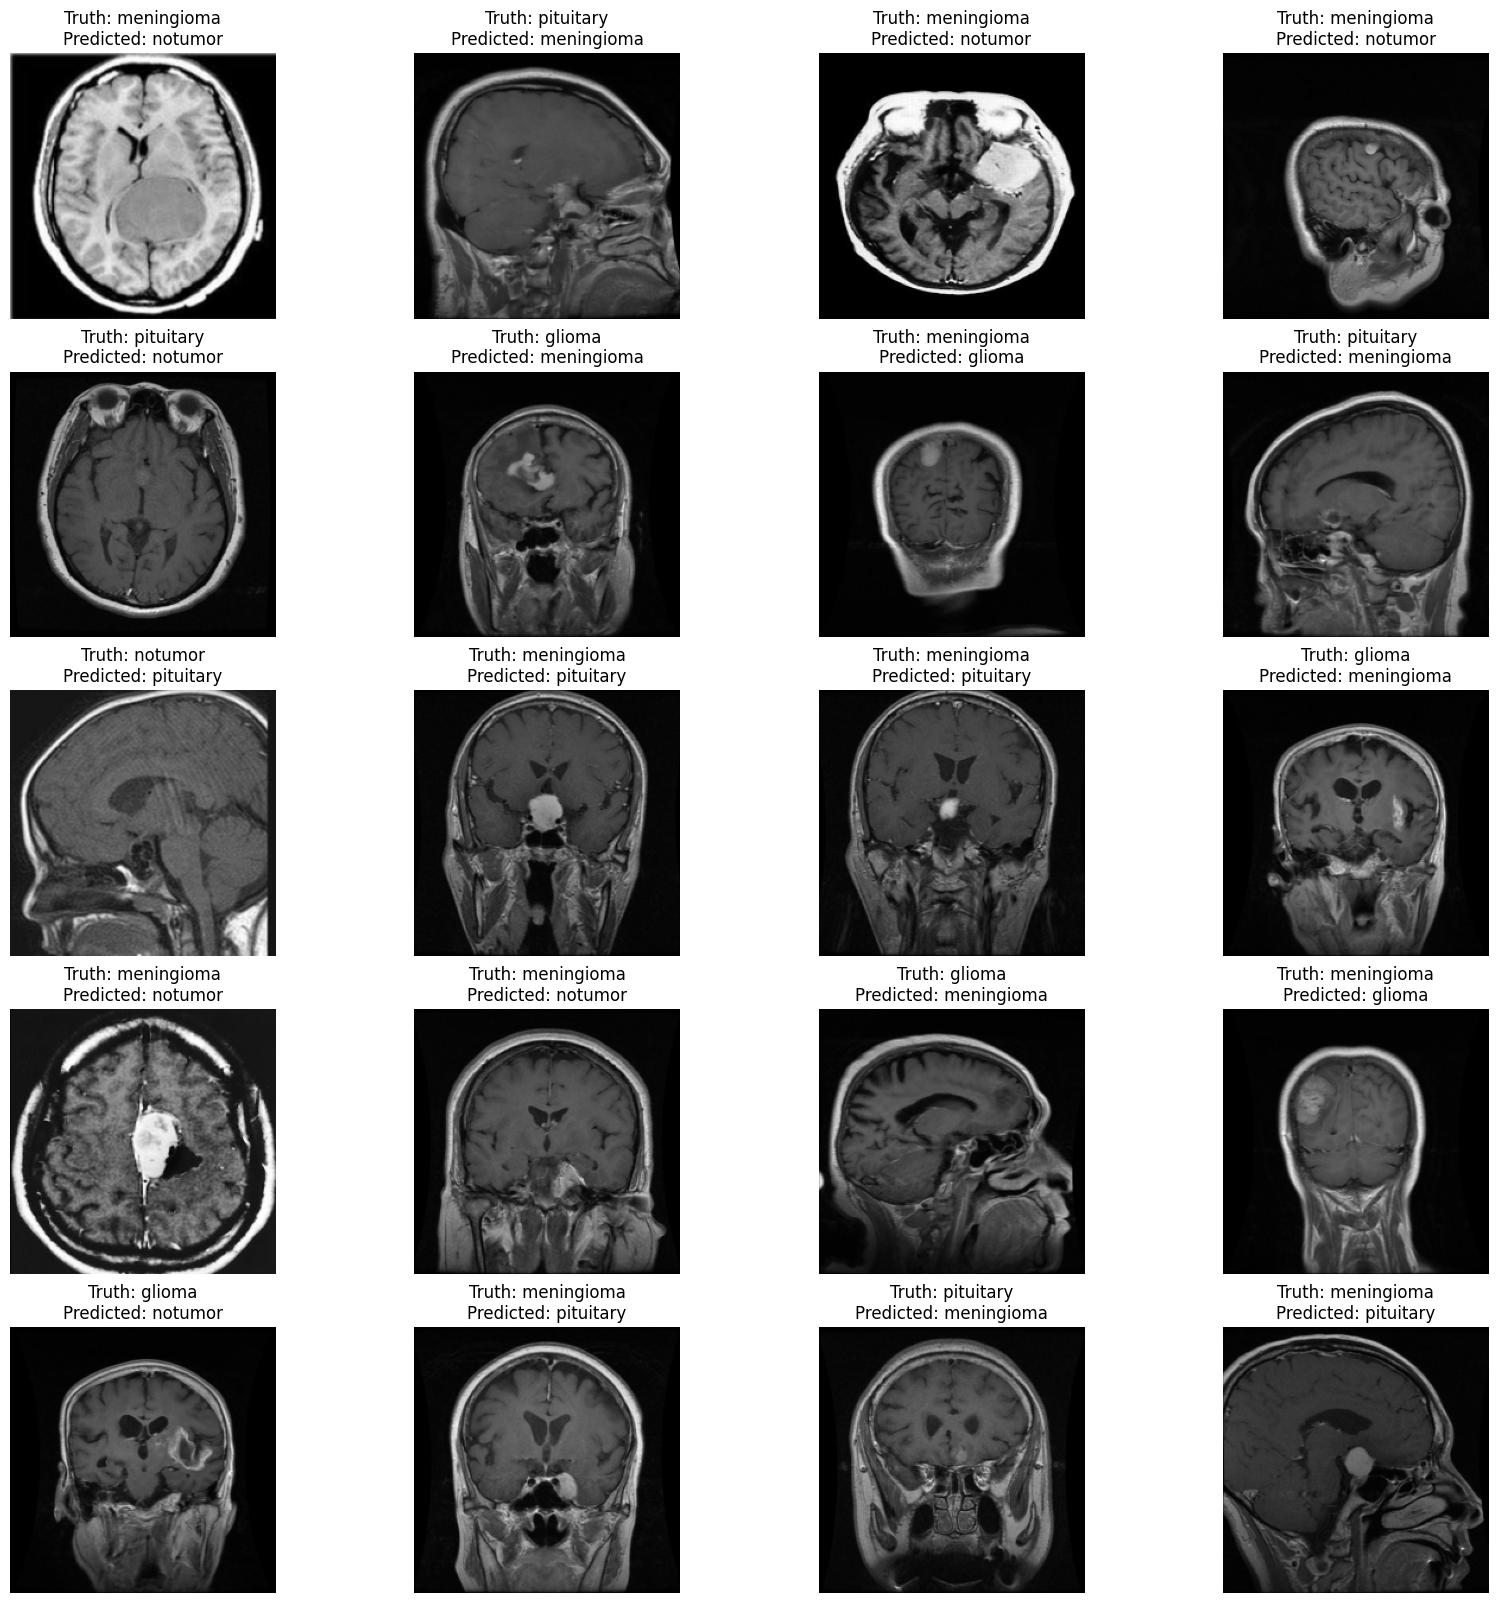

In [25]:
plt.figure(figsize=(20, 20))
for i, incorrect_idx in enumerate(incorrect_indices):  
    plt.subplot(5, 4, i % 20 + 1)
    plt.imshow(X_test[incorrect_idx])
    plt.title(f"Truth: {labels[Y_test[incorrect_idx]]}\nPredicted: {labels[y_pred[incorrect_idx]]}")
    plt.axis('off')
    if (i + 1) % 20 == 0:
        plt.show()
        plt.figure(figsize=(20, 20))
plt.show()